# Generating Toy Data/Model and Deploying to AdaFruit EdgeBadge

### Akshay Sridharan
#### Georgia Institute of Technology M.S. in Analytics Practicum Project with GE Research

Problem Statement: Design an anomaly detection workflow to detect anomalous movement using accelerometer readings. Deploy to an AdaFruit EdgeBadge for real-time inference.

### Plan of attack: 

##### Data Generation:
Toy accelerometer data will be loaded in from an AdaFruit EdgeBadge. The data will be sent to the device's serial port using the in-built AdaFruit magic_wand example code. The data will be read into Python from the serial port using pySerial (https://pyserial.readthedocs.io/en/latest/pyserial.html#overview) and further saved to a .csv for easy recreation of the workflow. It will be cleaned and stored using pandas as a multi-variate time series.

##### Data Description:
This data will consist of 3-channel accelerometer readings recorded over a 90 second interval at 25Hz. The first 60 seconds of the data will consist of "normal turbulence". This coincides with a typical, rhythmic movement of the device to synthetically emulate normal operating conditions of a machine (all is working well in our fake machine). The next 30 seconds of the data will consist of "anomalous turbulence". This coincides with an atypical, erratic movement of the device to synthetically emulate anomalous operating conditions of a machine (all is not well in our fake machine).

##### Anomaly Detection Approach:
In order to enact the anomaly detection, an autoencoder approach will be implemented. An autoencoder is a model that simply attempts to recreate the identity function for an input while minimizing the impact of overfitting. A neural network typically accomplishes this by compressing input information in intermediate layers and decompressing information in latter layers to effectively conduct lossy compression and decompression. The model is trained using the training data as both the input and response, thereby training the model to minimize compression loss caused in the smaller node cardinality intermediate layers. Thus, informally, the model is attempting to become quite good at reconstructing "normal turbulence" input signals, and will by design be quite poor at the reconstruction of "anomalous turbulence" input signals.

As this model is trained, a training loss distribution will be calculated. The loss used will be mean absolute error between input and output vectors, for the sake of simplicity. An upper threshold for the "normal turbulence" loss will be identified and used for the anomaly detection step. When streaming test or inference data to the model, normal signals will show low loss below the threshold value, while anomalous signals will lead to loss values above the threshold value. Thus, any loss calculated above the threshold value implies the input signal was anomalous.

### Importing Necessary Libraries

In [2]:
#Data creation and cleaning
import csv
from time import time
import serial
import pandas as pd
import numpy as np

#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

### Reading in data from serial port
Note: This step is only meant to be run for data generation. For reuse of the exact project data, the following cell may be skipped and the accompanying .csv may just be loaded in i.e. there is no need to rerun this cell unless you would like to create your own data (which requires running the magic_wand AdaFruit example prior to running the following cell).

In [3]:
#Obtaining data generated by randomized perturbations of accelerometer (shaking EdgeBadge with intentional anomalous shake at the very end for test set)
#Run this cell while running magic_wand example on Adafruit EdgeBadge to generate data then pulling values from Serial port
#Loop ends after samples have been collected

#Serial port will have to be user set and will need to correspond to EdgeBadge serial port value (found in Arduino IDE)
serial_port = '/dev/cu.usbmodem143101'
ser = serial.Serial(serial_port, timeout=1)

f = open("df.csv", "a+")
writer = csv.writer(f, delimiter=',')

#The number of samples will equal the recording frequency (25Hz) multiplied by the duration of the sample (90 seconds)
num_samples = 25*90

for i in range(num_samples):
    s = ser.readline().decode()
    if s != "":
        rows = [float(x) for x in s.split(',')]
        # Insert local time to list's first position
        rows.insert(0, time())
        print(rows)
        writer.writerow(rows)
        f.flush()
    
print("Collection finished!")

SerialException: [Errno 2] could not open port /dev/cu.usbmodem143101: [Errno 2] No such file or directory: '/dev/cu.usbmodem143101'

### Loading data from .csv

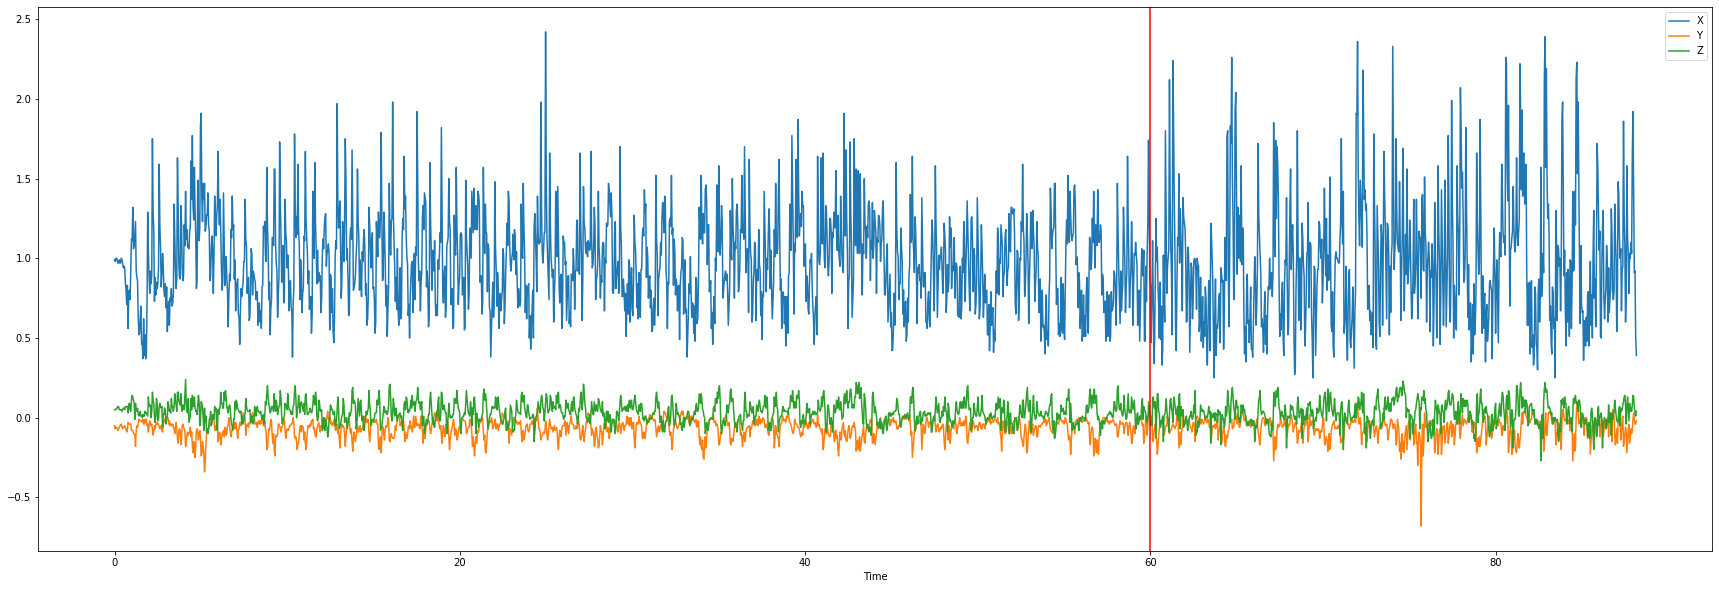

In [4]:
#Reading in raw data
data = pd.read_csv('df.csv', names=['Time', 'X', 'Y', 'Z'])

#Changing time to seconds elapsed
data.iloc[:,0] -= np.min(data.iloc[:,0])

#Displaying plot of accelerometer data across total time period
data.plot(x='Time', y=["X", "Y", 'Z'],
        kind="line", figsize=(30, 10))
plt.axvline(x=60, color='red')
plt.show()

In [11]:
data.

0      -0.05
1      -0.07
2      -0.06
3      -0.06
4      -0.07
        ... 
2245    0.03
2246   -0.01
2247   -0.04
2248   -0.04
2249   -0.02
Name: Y, Length: 2250, dtype: float64

In the above plot, the differences between the baseline 'normal turbulence' between the two increments can be observed, particularly in the X-axis accelerometer readings.

### Creating Train-Test Split and Formatting data

Splitting data into test and train samples. Train-Test split for each increment will be approximately 40-60.

In [5]:
train = data.iloc[0:int(0.4*len(data)),:]
test = data.iloc[(int(0.4*len(data)) + 1):,:]

#Setting time to be index value
traindf = train.set_index("Time", inplace=False)
testdf = test.set_index("Time", inplace=False)

#Converting traindf and testdf to arrays
train = np.array(traindf)
test = np.array(testdf)

#Reshaping data for compatibility with model [samples, timesteps, features]
train = train.reshape(train.shape[0], 1, train.shape[1])
print("Training data shape:", train.shape)
test = test.reshape(test.shape[0], 1, test.shape[1])
print("Test data shape:", test.shape)

Training data shape: (900, 1, 3)
Test data shape: (1349, 1, 3)


### Model Training

In [44]:
#Autoencoder with three dense layers and dropout
model1 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    Dense(train.shape[2], name = 'output'),
])

# model1 = autoencoder_model(i1train)
model1.compile(optimizer='adam', loss='mae')
model1.summary()

# Fitting each model to the data
nb_epochs = 100
batch_size = 10
history1 = model1.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 32)             128       
                                                                 
 dense_3 (Dense)             (None, 1, 8)              264       
                                                                 
 dropout_1 (Dropout)         (None, 1, 8)              0         
                                                                 
 output (Dense)              (None, 1, 3)              27        
                                                                 
Total params: 419
Trainable params: 419
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.3422 - val_loss: 0.2763
Epoch 2/100
86/86 [==============================] - 0s 1ms/step - loss: 0.2189 - val_los

86/86 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0398
Epoch 74/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0385
Epoch 75/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0379
Epoch 76/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0385
Epoch 77/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0377
Epoch 78/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0382
Epoch 79/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0394
Epoch 80/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0385
Epoch 81/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0391
Epoch 82/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0392
Epoch 83/100


##### Brief Modeling Note:

A very simple neural network was utilized in this portion of the project as the milestone is simply intended as a proof-of-concept. Issues arose when testing more complicated models (e.g. LSTM Autoencoder) due to subgraph structure and interpreter capabilities in the Arduino TensorFlow Lite packages. Further work will be required to explore the capacity for complex model support. This is the primary reason for the relatively poor training loss performance of the model.

### Model Loss Plots

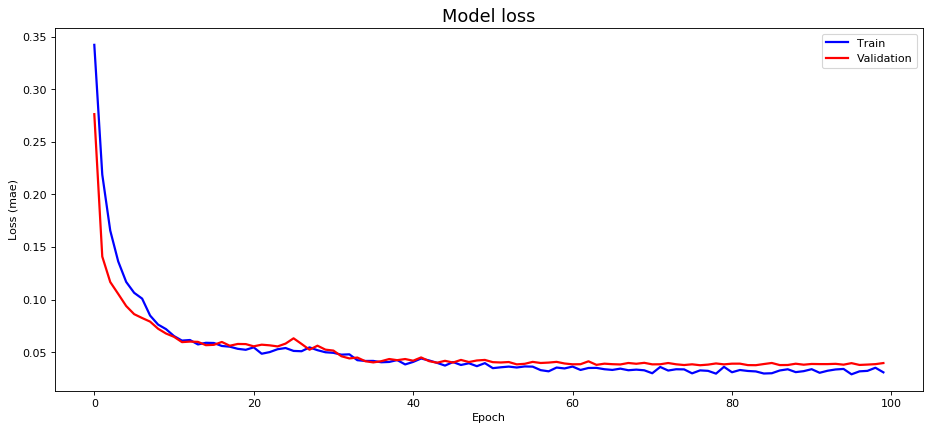

In [45]:
#Plotting training and validation loss for model
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1['loss'], 'b', label='Train', linewidth=2)
ax.plot(history1['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

29/29 [==============================] - 0s 754us/step
Threshold Value: 0.13
29/29 [==============================] - 0s 868us/step


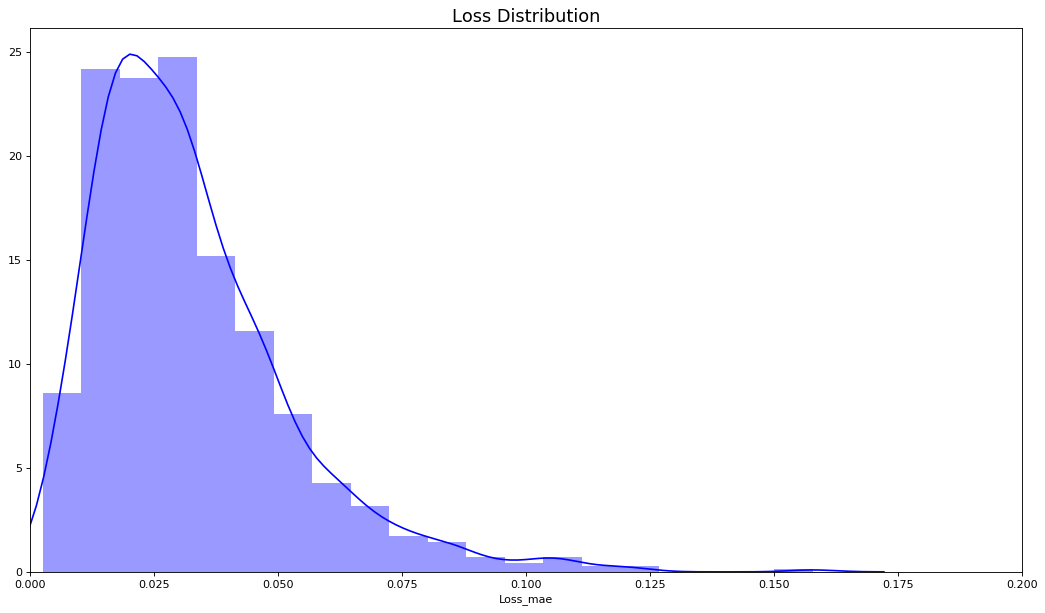

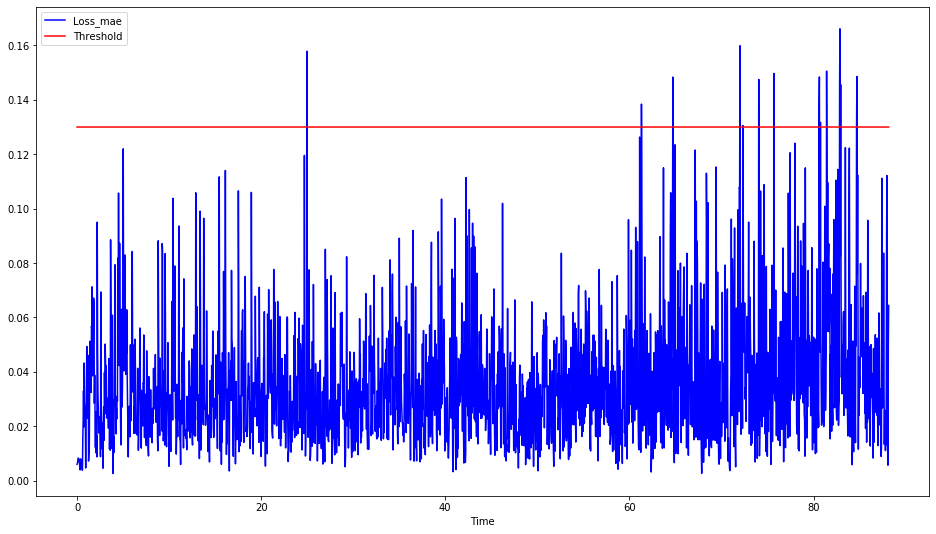

In [49]:
# Plotting distribution of loss function to establish reasonable threshold for anomaly detection

X_pred1 = model1.predict(train)
X_pred1 = X_pred1.reshape(X_pred1.shape[0], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=data.columns[1:4])
X_pred1.index = data.iloc[0:int(0.4*len(data)),0]

scored1 = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
Xtrain1 = train.reshape(train.shape[0], train.shape[2])
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-Xtrain1), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.2])

#Defining threshold values for loss anomaly detection
thresh = 0.13
print(f'Threshold Value: {thresh}')

#Computing test set loss and applying threshold value for anomaly detection
X_pred1 = model1.predict(test)
X_pred1 = X_pred1.reshape(X_pred1.shape[0], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=data.columns[1:4])
X_pred1.index = data.iloc[(int(0.4*len(data))+1):,0]

scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))+1):,0])
Xtest1 = test.reshape(test.shape[0], test.shape[2])
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-Xtest1), axis = 1)
scored1['Threshold'] = thresh
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

#Computing train set loss and applying threshold value
X_pred1_train = model1.predict(train)
X_pred1_train = X_pred1_train.reshape(X_pred1_train.shape[0], X_pred1_train.shape[2])
X_pred1_train = pd.DataFrame(X_pred1_train, columns=data.columns[1:4])
X_pred1_train.index = data.iloc[0:int(0.4*len(data)),0]

scored1_train = pd.DataFrame(index= data.iloc[0:int(0.4*len(data)),0])
Xtrain1 = train.reshape(train.shape[0], train.shape[2])
scored1_train['Loss_mae'] = np.mean(np.abs(X_pred1_train-Xtrain1), axis = 1)
scored1_train['Threshold'] = thresh
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

#Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in period preceding anomalous turbulence
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])

As there is some noise in the training data, a few values in the training set have MAE's that exceed the anomaly detection threshold. The threshold was set this low as repeated MAE's that exceed this threshold may be used to deem consistent anomalous behavior.

### Getting this to run on a microcontroller

In [9]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

  # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

    # Construct string from hex
        hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

  # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

#### Converting model to TFLite, then C array

In [63]:
run_model = tf.function(lambda x: model1(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model1.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
model1.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

#Saving models
with open('model1.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('c_model' + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, 'c_model'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets
=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #4 and tensor #3 as input and produces tensor #7 as output.

Subgraph#0 main(T#0) -> [T#9]
  Op#0 FULLY_CONNECTED(T#0, T#4, T#3) -> [T#7]
  Op#1 FULLY_CONNECTED(T#7, T#5, T#2) -> [T#8]
  Op#2 FULLY_CONNECTED(T#8, T#6, T#1) -> [T#9]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 1, 3], type:FLOAT32
  T#1(sequential_1/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential_1/dense_3/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#3(sequential_1/dense_2/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#4(sequential_1/dense_2/Tensordot/MatMul) shape:[32, 3], type:FLOAT32 RO 384 bytes
  T#5(sequential_1/dense_3/Tensordot/MatMul) shape:[8, 32], type:F

### SWAP-C and Accuracy Exploration

In [51]:
#Saving Tensorflow Model in Protocol Buffer Format
model1.save("model")

INFO:tensorflow:Assets written to: model/assets


In [62]:
#Calculating final training loss from Tensorflow model
tf_pred = model1.predict(train.astype('float32'))
tf_loss = np.mean(np.abs(tf_pred - train))
print(f'Full TensorFlow model Training Loss: {tf_loss}')

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()
# interpreter.resize_tensor_input(input_details[0]["index"], i1test.shape)
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

#Predictions from TFLite model
tfl_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl_pred[i,0,:] = result

tfl_loss = np.mean(np.abs(tfl_pred - train))
print(f'TensorFlow Lite model Training Loss: {tfl_loss}')

29/29 [==============================] - 0s 998us/step
Full TensorFlow model Training Loss: 0.03244832350843483
TensorFlow Lite model Training Loss: 0.03244832411689891
